<a href="https://colab.research.google.com/github/josenomberto/UTEC-CDIAV3-MISTI/blob/main/day3_kobe_model_validation_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**If you haven't already, please hit :**

`File` -> `Save a Copy in Drive`

**to copy this notebook to your Google drive, and work on a copy. If you don't do this, your changes won't be saved!**


# Model Validation with the Kobe Bryant Dataset

In [ ]:
# Import libraries for data manipulation and numerical analysis
import pandas as pd  # Data handling and manipulation
import numpy as np  # Numerical operations on arrays and matrices
import scipy.stats as st  # Statistical functions and distributions

# Import libraries for data visualization
%matplotlib inline
import matplotlib  # Core plotting library
import matplotlib.pyplot as plt  # Simplified interface for creating plots
import pylab as pl  # Alternative plotting interface
import seaborn as sns  # Advanced data visualization with attractive plots

# Import various machine learning classification algorithms
from sklearn.linear_model import LogisticRegression  # Logistic regression classifier
from sklearn.linear_model import SGDClassifier  # Stochastic Gradient Descent classifier
from sklearn.ensemble import GradientBoostingClassifier  # Gradient Boosting algorithm
from sklearn.ensemble import RandomForestClassifier  # Random Forest algorithm
from sklearn.ensemble import ExtraTreesClassifier  # Similar to Random Forest with more randomization

# Import library for dimensionality reduction
from sklearn.decomposition import PCA  # Principal Component Analysis (reduces features)

# Import libraries for cross-validation and model selection
from sklearn.model_selection import GridSearchCV  # Hyperparameter tuning using grid search
from sklearn.model_selection import train_test_split  # Splits data into training and test sets
from sklearn.model_selection import cross_val_predict  # Generates cross-validated estimates for predictions
from sklearn.model_selection import cross_val_score  # Evaluates model performance using cross-validation
from sklearn.model_selection import KFold  # K-Fold cross-validation splitting strategy
from sklearn import model_selection  # Provides additional utilities for model selection

# Import libraries for parallel processing to speed up computations
from joblib import Parallel, delayed  # Easy parallelization for tasks
import multiprocessing  # Handles multi-core processing

# Import libraries for text preprocessing and feature extraction
import re  # Regular expressions for text pattern matching
from nltk import PorterStemmer  # Stemming to reduce words to their root forms
from nltk.tokenize import word_tokenize  # Tokenizes text into words
from nltk.corpus import stopwords  # Removes common stopwords like 'the', 'and', etc.
from sklearn.feature_extraction.text import TfidfVectorizer  # Converts text to TF-IDF features
from sklearn.feature_extraction.text import CountVectorizer  # Converts text to count-based features

# Import libraries for model evaluation
from sklearn.metrics import roc_auc_score  # Metric to evaluate model's classification performance
from sklearn.metrics import confusion_matrix  # Evaluates predictions by comparing with actual labels
from sklearn.metrics import roc_curve, auc  # Plots and evaluates the ROC curve

# Suppress warnings to keep the output clean
import warnings
warnings.filterwarnings("ignore")

### Load the Data

In this section, we will load the Kobe Bryant dataset into a Pandas DataFrame and perform initial data cleaning to prepare it for analysis. We will filter the dataset to focus on 15 key features relevant to shot performance and remove records with missing values in the target variable (`shot_made_flag`). The resulting dataset will give us a cleaner and more manageable starting point for building predictive models.

In [ ]:
# load the data as a pandas dataframe
KobeDataset = pd.read_csv('KobeData.csv')
print("Data dimensions:" + str(KobeDataset.shape))

# we will narrow our focus to only the 15 features listed above
KobeDataset = KobeDataset.filter(["action_type", "loc_x", "loc_y","shot_distance", "shot_zone_basic", "shot_zone_area", "shot_type",
                                  "period", "minutes_remaining", "seconds_remaining", "playoffs", "season", "game_date","matchup", "shot_made_flag"])

print("Filtered Data dimensions:" + str(KobeDataset.shape))

#Clean Data
FullLength = len(KobeDataset)
KobeDataset = KobeDataset.loc[~pd.isnull(KobeDataset['shot_made_flag'])]
print("Removed", FullLength - len(KobeDataset), "records with null shot_made flag")

print("Filtered Data dimensions:" + str(KobeDataset.shape))

# display the first 10 lines
display(KobeDataset.head(10))

Data dimensions:(30697, 31)
Filtered Data dimensions:(30697, 15)
Removed 5000 records with null shot_made flag
Filtered Data dimensions:(25697, 15)


,action_type,loc_x,loc_y,shot_distance,shot_zone_basic,shot_zone_area,shot_type,period,minutes_remaining,seconds_remaining,playoffs,season,game_date,matchup,shot_made_flag
1,Jump Shot,-157,0,15.0,Mid-Range,Left Side(L),2PT Field Goal,1,10,22,0,2000-01,10/31/00,LAL @ POR,0.0
2,Jump Shot,-101,135,16.0,Mid-Range,Left Side Center(LC),2PT Field Goal,1,7,45,0,2000-01,10/31/00,LAL @ POR,1.0
3,Jump Shot,138,175,22.0,Mid-Range,Right Side Center(RC),2PT Field Goal,1,6,52,0,2000-01,10/31/00,LAL @ POR,0.0
4,Driving Dunk Shot,0,0,0.0,Restricted Area,Center(C),2PT Field Goal,2,6,19,0,2000-01,10/31/00,LAL @ POR,1.0
5,Jump Shot,-145,-11,14.0,Mid-Range,Left Side(L),2PT Field Goal,3,9,32,0,2000-01,10/31/00,LAL @ POR,0.0
6,Layup Shot,0,0,0.0,Restricted Area,Center(C),2PT Field Goal,3,8,52,0,2000-01,10/31/00,LAL @ POR,1.0
8,Jump Shot,-65,108,12.0,In The Paint (Non-RA),Left Side(L),2PT Field Goal,3,6,12,0,2000-01,10/31/00,LAL @ POR,1.0
9,Running Jump Shot,-33,125,12.0,In The Paint (Non-RA),Center(C),2PT Field Goal,3,3,36,0,2000-01,10/31/00,LAL @ POR,0.0
10,Jump Shot,-94,238,25.0,Above the Break 3,Left Side Center(LC),3PT Field Goal,3,1,56,0,2000-01,10/31/00,LAL @ POR,0.0
11,Jump Shot,121,127,17.0,Mid-Range,Right Side Center(RC),2PT Field Goal,1,11,0,0,2000-01,11/1/00,LAL vs. UTA,1.0


### Feature Engineering

#### Add in One-Hot Features

To improve the performance of our model, we start by generating **one-hot encoded columns** for each category in the `shot_zone_basic` feature. One-hot encoding transforms categorical variables into a format that machine learning algorithms can process, creating a separate binary column for each unique category. The new columns are named with the prefix **`shot_zone`**, corresponding to different shot zones on the court.

After generating these new features, we add them to the **KobeDataset** to enrich the dataset with location-based shooting information. Finally, we select a set of features that are likely to impact shot success, including **game time factors**, **shot distance**, **court locations**, and the newly created **shot zone features**. These selected features will be used as input for the **logistic regression model** to predict whether a shot was made (`shot_made_flag`).

In [ ]:
# Generate one-hot encoded columns for each category in 'shot_zone_basic'
# and use 'shot_zone' as the prefix for the new columns
shot_zones = pd.get_dummies(KobeDataset["shot_zone_basic"], prefix="shot_zone")

# Add this New Feature to your Dataset
KobeDataset = KobeDataset.join(shot_zones)

# Selecting a set of features for logistic regression
feat = ["minutes_remaining", "shot_distance", "loc_x", 'shot_zone_Above the Break 3', 'shot_zone_Backcourt', 'shot_zone_In The Paint (Non-RA)',
        'shot_zone_Left Corner 3','shot_zone_Mid-Range', 'shot_zone_Restricted Area', 'shot_zone_Right Corner 3']
label = ["shot_made_flag"]

#### Split the Data

Here, we split the cleaned dataset into three equal parts: training, validation, and test sets. The initial split divides the data into 50% training and 50% validation. The validation set is then further split evenly to create a separate test set. This ensures that we have distinct datasets for model training, tuning, and final performance evaluation, while maintaining consistency through fixed random seed values.

In [ ]:
train, val = train_test_split(KobeDataset, test_size= 0.5, train_size= 0.5, random_state= 234)
val, test = train_test_split(val, test_size= 0.5, train_size= 0.5, random_state= 675)

#### Replace Missing Values and Encode Categorical Data

In this section, we inspect the dataset's structure and check for missing values using info(). After identifying missing values in the shot_distance feature, we handle them by replacing the null values with the mean shot_distance from the respective split. This ensures that no critical feature is left incomplete, which could otherwise impact the performance of our predictive models. Finally, we check the dataset structure again to confirm that missing values have been handled appropriately.

In [ ]:
train["shot_distance"] = train["shot_distance"].fillna(np.mean(KobeDataset["shot_distance"]))
val["shot_distance"] = val["shot_distance"].fillna(np.mean(val["shot_distance"]))
test["shot_distance"] = test["shot_distance"].fillna(np.mean(test["shot_distance"]))

### Confusion Matrix



#### EXERCISE: Confusion Matrix with Logistic Regression
In this exercise, we'll use a confusion matrix to analyze the performance of a logistic regression model, which will show us how accurately it classifies Kobe Bryant's shots as made or missed.

Tasks:
1. Calculate the confusion matrix for the trained logistic regression using the `confusion_matrix()` function and plot it.
2. Extract the values from the confusion matrix using `conf_matrix.ravel()`. Use the extracted values to calculate the listed performance metrics. The confusion matrix contains the following values:
  - TP (True Positive)
  - TN (True Negative)
  - FP (False Positive)
  - FN (False Negative)

First, we fit a logistic regression using selected features and evaluating its performance on the validation set.

In [ ]:
# fit logistic regression
logReg = LogisticRegression()
logReg.fit(train[feat], train[label])

# predict on validation data
logReg_val_proba = pd.Series(logReg.predict_proba(val[feat])[:,1])

# Predict class labels on validation data
logReg_val_class = logReg.predict(val[feat])

##### TASK 1: Generate and Plot the Confusion Matrix

In [ ]:
# TASK 1 EXERCISE

# Create confusion matrix
conf_matrix = <REPLACE ME AND MY ARROWS>

# Plot confusion matrix using heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

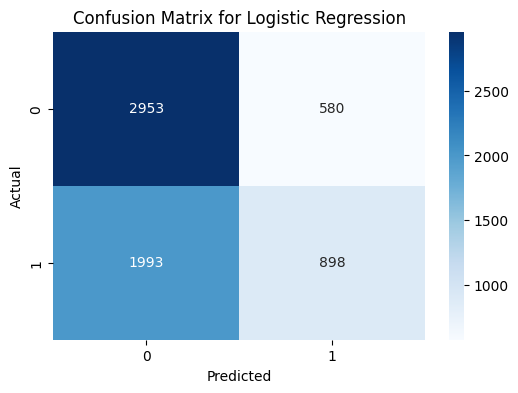

In [ ]:
# TASK 1 SOLUTION

# Create confusion matrix
conf_matrix = confusion_matrix(val[label], logReg_val_class)

# Plot confusion matrix using heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

##### TASK 2: Extract the Confusion matrix metrics and then Use them to Calculate Relevant Additional Metrics

In [ ]:
# TASK 2 EXERCISE

# Extract values from the confusion matrix
''' ADD YOUR CODE HERE '''

# Recall (Sensitivity or True Positive Rate)
recall_calculation = <REPLACE ME AND MY BRACKETS>

# Precision
precision_calculation = <REPLACE ME AND MY BRACKETS>

# Accuracy
accuracy_calculation = <REPLACE ME AND MY BRACKETS>

# Sensitivity (same as Recall or True Positive Rate)
sensitivity_calculation = <REPLACE ME AND MY BRACKETS>

# Specificity (True Negative Rate)
specificity_calculation = <REPLACE ME AND MY BRACKETS>

# False Positive Rate
false_positive_rate_calculation = <REPLACE ME AND MY BRACKETS>

# True Negative Rate (same as Specificity)
true_negative_rate_calculation = <REPLACE ME AND MY BRACKETS>

# True Positive Rate (same as Sensitivity or Recall)
true_positive_rate_calculation = <REPLACE ME AND MY BRACKETS>

# Print all calculated metrics based on the confusion matrix
calculated_metrics = {
    "Recall (Sensitivity/TPR)": recall_calculation,
    "Precision": precision_calculation,
    "Accuracy": accuracy_calculation,
    "Sensitivity": sensitivity_calculation,
    "Specificity (TNR)": specificity_calculation,
    "False Positive Rate (FPR)": false_positive_rate_calculation,
    "True Negative Rate (TNR)": true_negative_rate_calculation,
    "True Positive Rate (TPR)": true_positive_rate_calculation,
}

for metric, value in calculated_metrics.items():
    print(f"{metric}: {value:.4f}")

SyntaxError: invalid syntax (<ipython-input-108-9b759bc2b020>, line 7)

#### EXERCISE: Confusion Matrix with Gradient Boosting Classifier
Repeat the confusion matrix analysis, but this time using a gradient boosting classifier to see if the model improves in accuracy or specific metrics over logistic regression.

Tasks:
1. Calculate the confusion matrix for the trained gradient boosting classifier using the `confusion_matrix()` function and plot it.
2. Extract the values from the confusion matrix using `conf_matrix.ravel()`. Again, use the extracted values to calculate the listed performance metrics. The confusion matrix contains the following values:
  - TP (True Positive)
  - TN (True Negative)
  - FP (False Positive)
  - FN (False Negative)
3. Compare the calculated performance metrics between the `LogisticRegression()` and the `GradientBoostingClassifier()`. What are the pros and cons for each of these models for this data set (for this particular model training output)?

In [ ]:
# Train gradient boosting classifier
gbm = GradientBoostingClassifier()
gbm.fit(train[feat], train[label])

# Predict on the validation set
gbm_val_predictions = gbm.predict(val[feat])

##### TASK 1: Generate and Plot the Confusion Matrix

In [ ]:
# TASK 1 EXERCISE

# Create confusion matrix
conf_matrix = <REPLACE ME AND MY ARROWS>

# Plot confusion matrix for gradient boosting
plt.figure(figsize=(6, 4))
sns.heatmap(gbm_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Gradient Boosting Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

SyntaxError: invalid syntax (<ipython-input-111-6a3ec810e704>, line 4)

##### TASK 2: Extract the Confusion matrix metrics and then Use them to Calculate Relevant Additional Metrics

In [ ]:
# TASK 2 EXERCISE

# Extract values from the confusion matrix
''' ADD YOUR CODE HERE '''

# Recall (Sensitivity or True Positive Rate)
recall_calculation_gbm = <REPLACE ME AND MY BRACKETS>

# Precision
precision_calculation_gbm = <REPLACE ME AND MY BRACKETS>

# Accuracy
accuracy_calculation_gbm = <REPLACE ME AND MY BRACKETS>

# Sensitivity (same as Recall or True Positive Rate)
sensitivity_calculation_gbm = <REPLACE ME AND MY BRACKETS>

# Specificity (True Negative Rate)
specificity_calculation_gbm = <REPLACE ME AND MY BRACKETS>

# False Positive Rate
false_positive_rate_calculation_gbm = <REPLACE ME AND MY BRACKETS>

# True Negative Rate (same as Specificity)
true_negative_rate_calculation_gbm = <REPLACE ME AND MY BRACKETS>

# True Positive Rate (same as Sensitivity or Recall)
true_positive_rate_calculation_gbm = <REPLACE ME AND MY BRACKETS>

# Print all calculated metrics based on the confusion matrix
calculated_metrics_gbm = {
    "Recall (Sensitivity/TPR)": recall_calculation_gbm,
    "Precision": precision_calculation_gbm,
    "Accuracy": accuracy_calculation_gbm,
    "Sensitivity": sensitivity_calculation_gbm,
    "Specificity (TNR)": specificity_calculation_gbm,
    "False Positive Rate (FPR)": false_positive_rate_calculation_gbm,
    "True Negative Rate (TNR)": true_negative_rate_calculation_gbm,
    "True Positive Rate (TPR)": true_positive_rate_calculation_gbm,
}

for metric, value in calculated_metrics_gbm.items():
    print(f"{metric}: {value:.4f}")

SyntaxError: invalid syntax (<ipython-input-113-b9764179910b>, line 7)

#### TASK 3: Compare the Performance Metrics

In [ ]:
# TASK 3 SOLUTION AND EXERCISE

# Print the Metrics for the `LogisticRegression()`
print('Logistic Regression Metrics: \n')
for metric, value in calculated_metrics.items():
    print(f"{metric}: {value:.4f}")

print('\n ----- \n')

# Print the performance metrics for the `GradientBoostingClassifier()`
print('Gradient Boosted Decision Tree Metrics: \n')
for metric, value in calculated_metrics_gbm.items():
    print(f"{metric}: {value:.4f}")

Logistic Regression Metrics: 

Recall (Sensitivity/TPR): 0.3106
Precision: 0.6076
Accuracy: 0.5995
Sensitivity: 0.3106
Specificity (TNR): 0.8358
False Positive Rate (FPR): 0.1642
True Negative Rate (TNR): 0.8358
True Positive Rate (TPR): 0.3106

 ----- 

Gradient Boosted Decision Tree Metrics: 

Recall (Sensitivity/TPR): 0.3037
Precision: 0.6064
Accuracy: 0.5979
Sensitivity: 0.3037
Specificity (TNR): 0.8387
False Positive Rate (FPR): 0.1613
True Negative Rate (TNR): 0.8387
True Positive Rate (TPR): 0.3037


### Reciever Operating Characteristic Curves and Area Under the Curve Metrics

#### EXERCISE: Calculate the Receiver Operator Characteristic Curve and Area under the Curve (AUC) for Logistic Regression

In this exercise, we'll plot and analyze the ROC curve and calculate the AUC metric to evaluate our model's performance across different classification thresholds. This will help us understand how well our model discriminates between made and missed shots at various sensitivity levels. We will compare the ROC output from two different models.

Tasks:
1. Calculate the values necessary to plot an ROC curve for the `LogisticRegressionClassifier()`:
  - Do this manually first:
    - For each threshold, compare `y_prob` (predicted probabilities) with the threshold to create `y_pred` (predicted labels).
    - Calculate the following values:
      - TP (True Positives): Number of correctly predicted positive samples.
      - FP (False Positives): Number of negative samples incorrectly predicted as positive.
      - FN (False Negatives): Number of positive samples incorrectly predicted as negative.
      - TN (True Negatives): Number of correctly predicted negative samples.
  - Next, calculate this using the provided function: `roc_curve(~)`.
  - Finally, calculate the AUC metrics using the provided function `auc(~)`.
2. Calculate the metrics necessary to plot an ROC curve and it's AUC metric using the functions for the `GradientBoostingClassifier()`.
3. Compare the two ROC curves.

In [ ]:
# True Validation Labels
y_val = val[label].values

# fit logistic regression
logReg = LogisticRegression()
logReg.fit(train[feat], train[label])

# Predict on the validation set
y_prob_logReg = logReg.predict_proba(val[feat])[:, 1]

# Calculate ROC AUC Score
print("Logistic Regression Performance (ROC AUC): " + str(np.round(roc_auc_score(val[label], y_prob_logReg), 5)))

# Train gradient boosting classifier
gbm = GradientBoostingClassifier()
gbm.fit(train[feat], train[label])

# Predict on the validation set
y_prob_gbm = gbm.predict_proba(val[feat])[:, 1]

# Calculate ROC AUC Score
print("Gradient Boosting Performance (ROC AUC): " + str(np.round(roc_auc_score(val[label], y_prob_gbm), 5)))

Logistic Regression Performance (ROC AUC): 0.6009
Gradient Boosting Performance (ROC AUC): 0.60121


##### TASK 1: `LogisticRegression()` ROC and AUC Calculations

In [ ]:
# TASK 1 EXERCISE

# MANUAL ROC CALCULATION ----------------------------------------------------------

tprs = []
fprs = []
thresholds = <REPLACE ME AND MY ARROWS>
y_prob_logReg = logReg.predict_proba(val[feat])[:, 1]
y_true = val[label].values[:, 0]

# Loop through each threshold to calculate TPR and FPR
for threshold in thresholds:

    # Binarize predictions based on the threshold
    y_pred = <REPLACE ME AND MY ARROWS>

    # True Positives, False Positives, True Negatives, False Negatives
    TP = ((y_pred == <REPLACE ME AND MY ARROWS>) & (y_true == <REPLACE ME AND MY ARROWS>)).sum()
    FP = ((y_pred == <REPLACE ME AND MY ARROWS>) & (y_true == <REPLACE ME AND MY ARROWS>)).sum()
    TN = ((y_pred == <REPLACE ME AND MY ARROWS>) & (y_true == <REPLACE ME AND MY ARROWS>)).sum()
    FN = ((y_pred == 0<REPLACE ME AND MY ARROWS>) & (y_true == <REPLACE ME AND MY ARROWS>)).sum()

    # Calculate TPR and FPR
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)

    tprs.append(tpr)
    fprs.append(fpr)

# Convert to numpy arrays
tprs = np.array(tprs)
fprs = np.array(fprs)

# Calculate the area under the curve (AUC) manually
roc_auc = np.trapz(tprs, fprs)

# ROC CALCULATION WITH FUNCTIONS ----------------------------------------------------------
fprs_function_lr, tprs_function_lr, _ = roc_curve(val[label], y_prob_logReg)
roc_auc_function_LogReg = auc(fprs_function_lr, tprs_function_lr)

plt.figure()
plt.plot(fprs, tprs, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})', marker = 'x')
plt.plot(fprs_function_lr, tprs_function_lr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_function_LogReg:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - LogisticRegression')
plt.legend(loc="lower right")
sns.despine()
plt.show()

SyntaxError: invalid syntax (<ipython-input-134-740bb6665c9f>, line 8)

##### TASK 2: `GradientBoostingClassifier()` ROC and AUC Calculations

In [ ]:
# TASK 2 EXERCISE

# ROC CALCULATION WITH FUNCTIONS ----------------------------------------------------------
y_prob_gbm = gbm.predict_proba(val[feat])[:, 1]
fprs_function_gbm, tprs_function_gbm, _ = <REPLACE ME AND MY ARROWS>
roc_auc_function_gbm = <REPLACE ME AND MY ARROWS>

plt.figure()
plt.plot(fprs_function_gbm, tprs_function_gbm, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_function:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - GBM')
plt.legend(loc="lower right")
sns.despine()
plt.show()

SyntaxError: invalid syntax (<ipython-input-118-b237f8a2ad0a>, line 5)

##### TASK 3: Comparison of ROC and AUC Performance

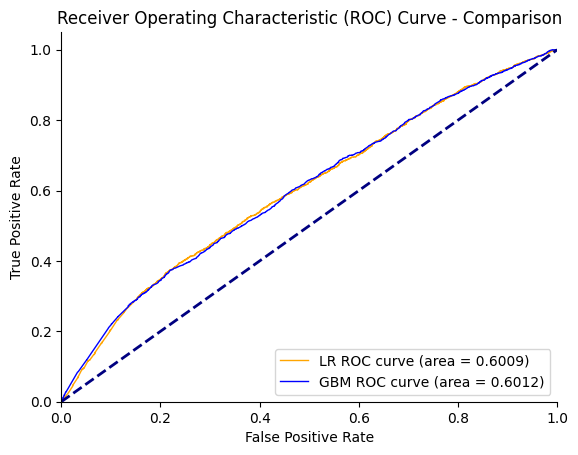

In [ ]:
# TASK 3 EXERCISE AND SOLUTION

plt.figure()
plt.plot(fprs_function_lr, tprs_function_lr, color='orange', lw=1, label=f'LR ROC curve (area = {roc_auc_function_LogReg:.4f})')
plt.plot(fprs_function_gbm, tprs_function_gbm, color='blue', lw=1, label=f'GBM ROC curve (area = {roc_auc_function_gbm:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Comparison')
plt.legend(loc="lower right")
sns.despine()
plt.show()